In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data_p = r"/kaggle/input/playground-series-s5e2/train.csv"
data_p_ex = r"/kaggle/input/playground-series-s5e2/training_extra.csv"
test = r"/kaggle/input/playground-series-s5e2/test.csv"
data = pd.concat([pd.read_csv(data_p), pd.read_csv(data_p_ex)])
test_data = pd.read_csv(test)

In [3]:
data.describe()

,id,Compartments,Weight Capacity (kg),Price
count,3.994318e+06,3.994318e+06,3.992510e+06,3.994318e+06
mean,2.182137e+06,5.434740e+00,1.801042e+01,8.136217e+01
std,1.178058e+06,2.893043e+00,6.973969e+00,3.893868e+01
min,0.000000e+00,1.000000e+00,5.000000e+00,1.500000e+01
25%,1.198579e+06,3.000000e+00,1.206896e+01,4.747002e+01
50%,2.197158e+06,5.000000e+00,1.805436e+01,8.098495e+01
75%,3.195738e+06,8.000000e+00,2.398751e+01,1.148550e+02
max,4.194317e+06,1.000000e+01,3.000000e+01,1.500000e+02


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 365.7+ MB


In [5]:
data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [6]:
data = data.drop(columns="id")

In [7]:
for i in data.columns:
    print(i, data[i].nunique())

Brand 5
Material 4
Size 3
Compartments 10
Laptop Compartment 2
Waterproof 2
Style 3
Color 6
Weight Capacity (kg) 1920345
Price 48358


In [8]:
data.isna().sum()

Brand                   126758
Material                110962
Size                     87785
Compartments                 0
Laptop Compartment       98533
Waterproof               94324
Style                   104180
Color                   133617
Weight Capacity (kg)      1808
Price                        0
dtype: int64

In [9]:
compartments = sorted(data['Compartments'].unique())
isnotna_sums=[]
for comp in compartments:
    isnotna_sums.append(data[data["Compartments"]==comp].count()+data[data["Compartments"]==comp].isna().sum())
a = pd.DataFrame(isnotna_sums).T
a.columns = compartments
a["sum"] = a.apply(lambda x: x.sum(), axis=1)
a.iloc[:,:] + a.apply(lambda x: x.sum(), axis=0)
a
isna_sums=[]
for comp in compartments:
    isna_sums.append(data[data["Compartments"]==comp].isna().sum())
b = pd.DataFrame(isna_sums).T
b.columns = compartments
b["sum"] = b.apply(lambda x: x.sum(), axis=1)
compartments_sum = pd.DataFrame((b.apply(lambda x: x.sum(), axis=0)/a.apply(lambda x: x.sum(), axis=0))*100).T
c=b/a
c=(c[c.apply(lambda x: False if x.sum()==0 else True, axis=1)]*100)
c = pd.concat([c,compartments_sum])

In [10]:
cat = data.select_dtypes(["category","object"])

<Axes: xlabel='Weight Capacity (kg)', ylabel='Count'>

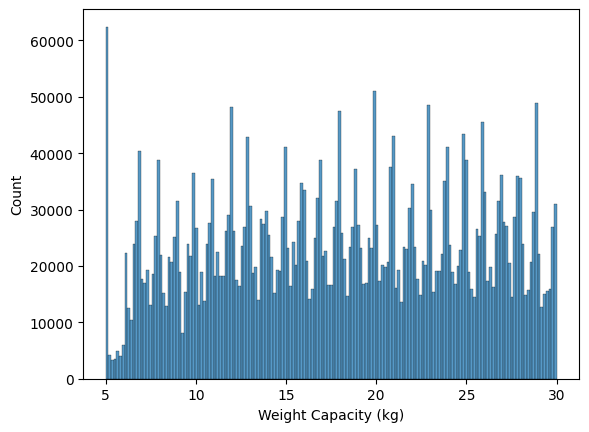

In [11]:
sns.histplot(data["Weight Capacity (kg)"])

<Axes: >

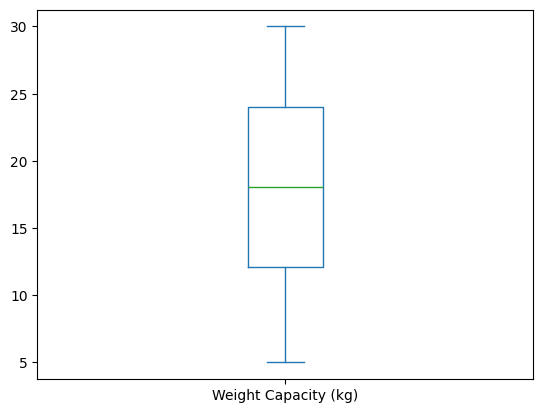

In [12]:
data["Weight Capacity (kg)"].plot(kind="box")

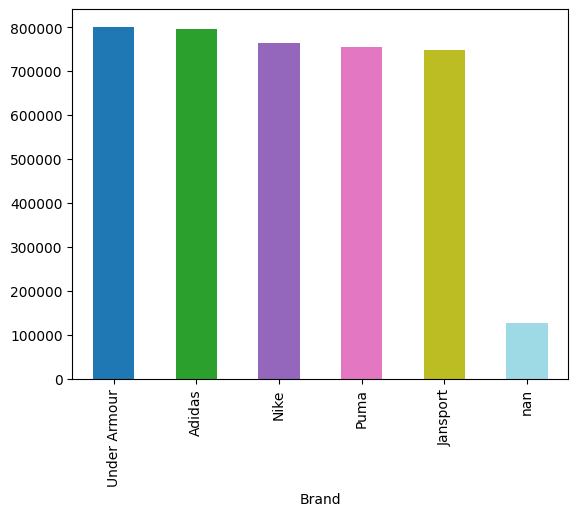

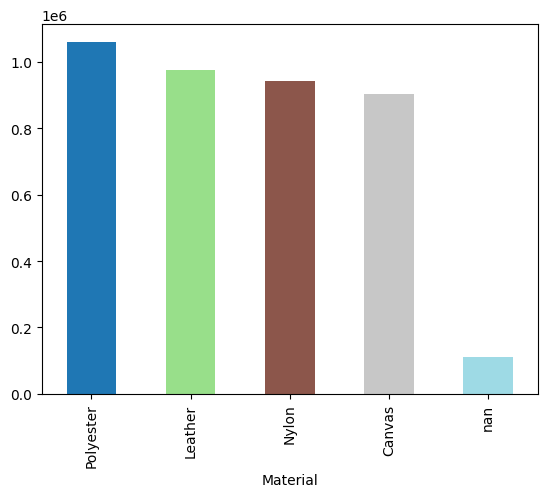

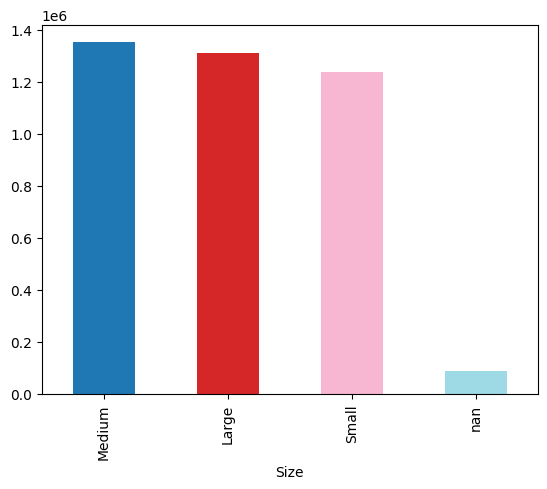

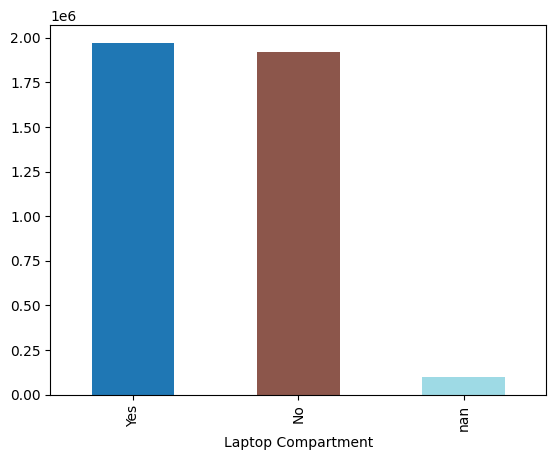

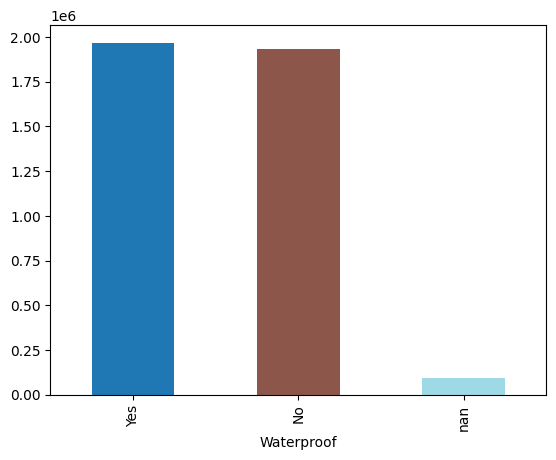

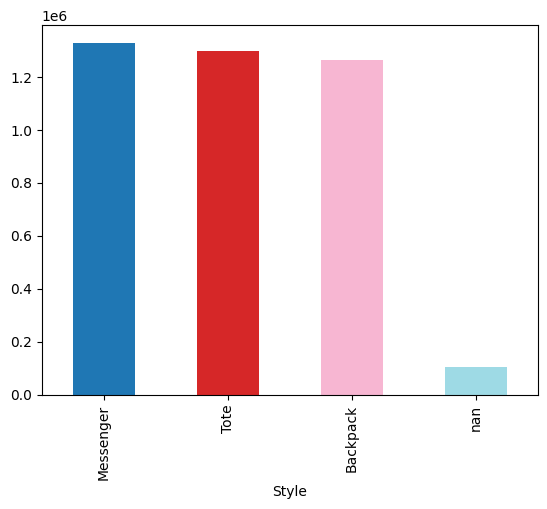

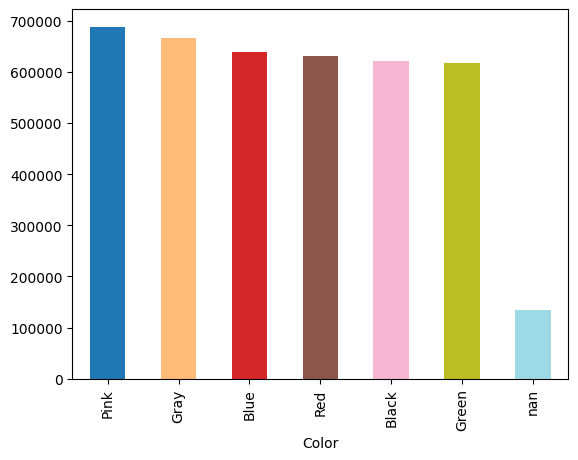

In [13]:
for i in cat.columns:
    ccol = cat[i].value_counts(dropna=False)
    colors = plt.get_cmap('tab20', len(ccol))
    colors = [colors(i) for i,j in enumerate(ccol)]
    ccol.plot(kind="bar", color=colors)
    plt.show()

(0.0, 215073.1)

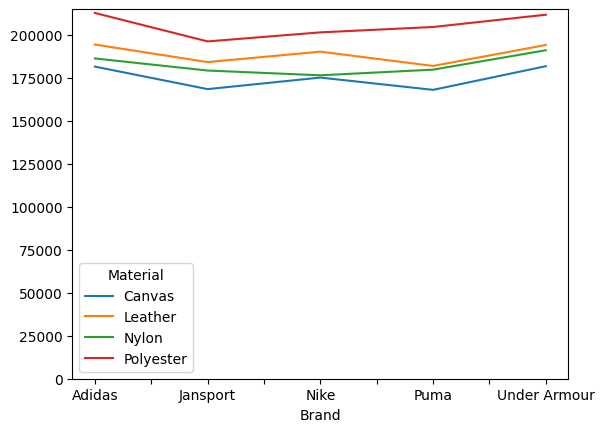

In [14]:
ax = data.pivot_table(index="Brand", columns="Material", aggfunc="size").plot()
ax.set_ylim(0,None)

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error

In [17]:
dependent = data["Price"]
independent = data.drop(columns=["Price"])

In [18]:
onehot_cols = ["Color","Brand","Material","Style"]
ordinal_cols = ["Size","Laptop Compartment", "Waterproof"]
numeric_cols = ["Weight Capacity (kg)", "Compartments"]
cat_cols = independent.select_dtypes(["object", "category"]).columns
num_cols = independent.select_dtypes(["number"]).columns

In [19]:
cat_imputer = SimpleImputer(strategy="constant", fill_value="na")
num_imputer = SimpleImputer(strategy="constant", fill_value=-1)
onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ordinal = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
scaler = MinMaxScaler()

In [22]:
imputer_transformer = ColumnTransformer([
    ("cat_imputer", cat_imputer, cat_cols),
    ("num_imputer", num_imputer, num_cols)
])

In [23]:
imputer_transformer.fit(independent)

ColumnTransformer(transformers=[('cat_imputer',
                                 SimpleImputer(fill_value='na',
                                               strategy='constant'),
                                 Index(['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof',
       'Style', 'Color'],
      dtype='object')),
                                ('num_imputer',
                                 SimpleImputer(fill_value=-1,
                                               strategy='constant'),
                                 Index(['Compartments', 'Weight Capacity (kg)'], dtype='object'))])

In [24]:
independent_imputed = pd.DataFrame(imputer_transformer.transform(independent), columns=list(cat_cols)+list(num_cols))
test_imputed = pd.DataFrame(imputer_transformer.transform(test_data), columns=list(cat_cols)+list(num_cols))

In [25]:
preprocessor_encode = ColumnTransformer([
    ("onehot", onehot, onehot_cols),
    ("ordinal", ordinal, ordinal_cols),
    ("scaler", scaler, num_cols)
    ])

In [27]:
preprocessor_encode.fit(independent_imputed)

ColumnTransformer(transformers=[('onehot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Color', 'Brand', 'Material', 'Style']),
                                ('ordinal',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['Size', 'Laptop Compartment', 'Waterproof']),
                                ('scaler', MinMaxScaler(),
                                 Index(['Compartments', 'Weight Capacity (kg)'], dtype='object'))])

In [28]:
independent_data = pd.DataFrame(preprocessor_encode.transform(independent_imputed), columns=list(preprocessor_encode.named_transformers_["onehot"].get_feature_names_out(onehot_cols))+ordinal_cols+ list(num_cols))
test_data = pd.DataFrame(preprocessor_encode.transform(test_imputed), columns=list(preprocessor_encode.named_transformers_["onehot"].get_feature_names_out(onehot_cols))+ordinal_cols+ list(num_cols))

In [29]:
independent_data.head()

,Color_Black,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Color_na,Brand_Adidas,Brand_Jansport,Brand_Nike,...,Material_na,Style_Backpack,Style_Messenger,Style_Tote,Style_na,Size,Laptop Compartment,Waterproof,Compartments,Weight Capacity (kg)
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.666667,0.406830
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.000000,0.905759
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.111111,0.569154
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.777778,0.449588
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.000000,0.604817


In [30]:
x_train, x_test, y_train, y_test = train_test_split(independent_data, dependent, test_size=0.2, random_state=1)

In [31]:
lm = LinearRegression()
lm.fit(x_train, y_train)
test_predictions = lm.predict(x_test)
root_mean_squared_error(y_test,test_predictions)

38.90444756961099

In [34]:
param_grid = {
    "fit_intercept": [True, False],
    "copy_X": [True, False]
}
grid_search = GridSearchCV(lm, param_grid, cv=7, scoring='r2', n_jobs=10)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=7, estimator=LinearRegression(), n_jobs=10,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='r2')

In [35]:
best = grid_search.best_estimator_
best_predictions = best.predict(x_test)
root_mean_squared_error(y_test, best_predictions)

38.90444756961101

In [36]:
predictions = best.predict(test_data)
output = pd.DataFrame(predictions.round(3)).reset_index().rename(columns={0:"Price", 'index':'id'})
output['id'] += 300000
output.to_csv("submission.csv", index=False)